In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Determine the data types and columns for the Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Determine the data types and columns for the Station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(latest_date)

2017-08-23


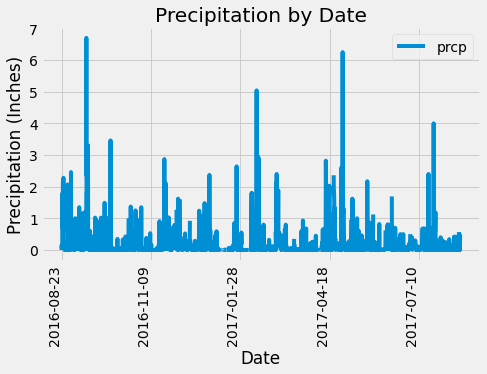

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_from_latest = (dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days = 365)).strftime("%Y-%m-%d")
year_from_latest

# Perform a query to retrieve the data and precipitation scores
query = "SELECT date, prcp FROM measurement WHERE date >= '2016-08-23' order by date;"

# Save the query results as a Pandas DataFrame and set the index to the date column
conn = engine.connect()
data_df = pd.read_sql(query, conn).set_index('date')

# Sort the dataframe by date 
data_df = data_df.sort_values('date')
data_df

# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot(figsize=(7,4))
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Date')
plt.title("Precipitation by Date")
plt.xticks(rotation=90, ha='right')
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station).count()
num_stations

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for item in activity:
    print(item)
print(f"The most active station is {activity[0][0]} with {activity[0][1]} measurements.")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is USC00519281 with 2772 measurements.


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_summary = session.query(Measurement.station,\
                                func.min(Measurement.tobs),\
                                func.max(Measurement.tobs),\
                                func.avg(Measurement.tobs)).\
                    filter(Measurement.station == 'USC00519281').all()

print(f"The most active station ({station_summary[0][0]}) \nrecorded a minimum temperature of {station_summary[0][1]}, \na maximum temperature of {station_summary[0][2]}, \nand an average temperature of {round(station_summary[0][3], 2)}")

The most active station (USC00519281) 
recorded a minimum temperature of 54.0, 
a maximum temperature of 85.0, 
and an average temperature of 71.66


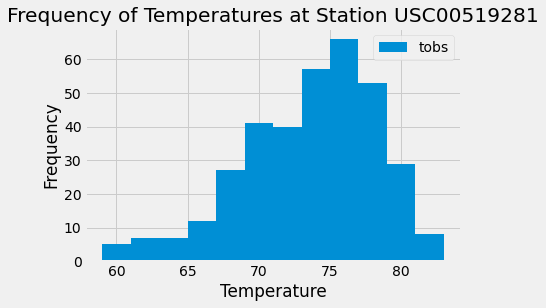

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Queries the database
station_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281', Measurement.date >= year_from_latest).order_by(Measurement.date).all()
# Loads the query into a DataFrame
station_df = pd.DataFrame(station_temp).set_index('date')

# Plots the histogram
station_df.plot.hist(by='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Frequency of Temperatures at Station USC00519281')

plt.show()

# Close session

In [18]:
# Close Session
session.close()